# Text Clustering Basics

In this snippet we use the clustering algorithm k-means, to be precise we use the mini batch k-means algorithm, to cluster text. For that we use the newsgroup dataset from scikit-learn. We will only use three the documents catgeories 'talk.politics.misc', 'talk.religion.misc' and 'talk.politics.guns'. 

In [210]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn import cluster, datasets, manifold, utils, preprocessing, decomposition, pipeline, metrics
from sklearn.feature_extraction import text

We are only interested in the documents categories politics, religion and guns. The other categories are ignored for our example.

In [211]:
categories = ['talk.politics.misc', 'talk.religion.misc', 'talk.politics.guns']
dataset = datasets.fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=False, random_state=42, download_if_missing=True)

print(dataset.target_names)

['talk.politics.guns', 'talk.politics.misc', 'talk.religion.misc']


In [212]:
print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))

2313 documents
3 categories


We use the TF-IDF vectorizer to build convert the text documents to features.  Per default we use words as features. You could also use character n-grams instead of words as features. There are plenty of options to tune your model, which have an impact which features are used in the final model.

In [214]:
vectorizer = text.TfidfVectorizer(analyzer='word', max_df=0.8, max_features=1000,
                                 min_df=2, stop_words='english',
                                 use_idf=True)
X = vectorizer.fit_transform(dataset.data)
print(X.shape)

(2313, 1000)


In [202]:
svd = decomposition.TruncatedSVD(n_components=2)
normalizer = preprocessing.Normalizer(copy=False, norm='l2')
lsa = pipeline.make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)

In [203]:
n_clusters = 3
kmeans = cluster.MiniBatchKMeans(n_clusters=n_clusters, random_state=1)
label = kmeans.fit_predict(X)

In [204]:
df = pd.DataFrame(X, columns=['X', 'Y'])
df['label'] = label

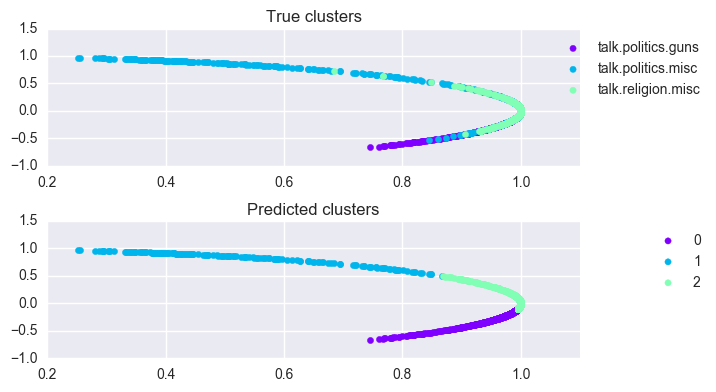

In [205]:
fig = plt.figure()
colors = [cm.rainbow(i/(n_clusters + 1)) for i in range(n_clusters)]

ax = fig.add_subplot(211)
for i in range(len(dataset.target_names)):
    plt.scatter(df[dataset.target == i].X, df[dataset.target == i].Y, color=colors[i], label=dataset.target_names[i])

ax.set_title('True clusters')
plt.legend(bbox_to_anchor=(1.25, 1))

ax = fig.add_subplot(212)
for i in range(n_clusters):
    plt.scatter(df[df.label == i].X, df[df.label == i].Y, color=colors[i], label=i)
    

ax.set_title('Predicted clusters')
plt.legend(bbox_to_anchor=(1.25, 1))

fig.tight_layout()

In [206]:
metrics.adjusted_rand_score(dataset.target, label)

0.18820323652347451

In [207]:
metrics.adjusted_mutual_info_score(dataset.target, label)

0.19426471926684308

In [208]:
metrics.accuracy_score(dataset.target, label)

0.5884133160397752